end_to_end_Net
loss_fn: tensor(11.1318, device='cuda:0', dtype=torch.float64)
predict_dist_error:21.0
fog_dist_error:18.0
clear_dist_error:0.0
predict_phase_error:0.0
fog_phase_error:0.0
clear_phase_error:0.0


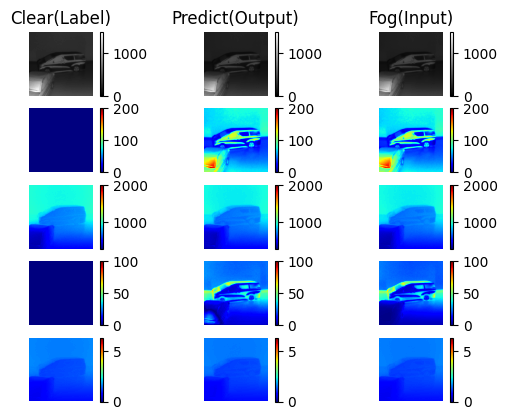

In [33]:
# import os
import torch
from torchvision import transforms as T
import numpy as np
import matplotlib.pyplot as plt
from Src.ComplexValuedAutoencoderMain_Torch import end_to_end_Net
from train_and_eval import loss_fn

DistanceScale=[0,4000]
vmin_depth = 300
vmax_depth = 2000

vmin_amp = 0
vmax_amp = 1500

vmin_error = 0
vmax_error = 200

vmin_phase_error = 0
vmax_phase_error = np.pi

isComplexModel = True
needOffset = True

CONST_C = 299792458 #speed of light (m/s)
CONST_F = 40*1e6 #modulation frequency (Hz) 

def main():
    weights_path = 'save_weights/best_model.pth'
    
    fog_amp_path = 'syn_data_v2/predict/syn_amp_1214_10_0025.npy'
    fog_phase_path = 'syn_data_v2/predict/syn_phase_1214_10_0025.npy'
    
    label_phase_path = 'syn_data_v2/predict/sample_phase_1214_10_0025.npy'
    label_amp_path = 'syn_data_v2/predict/sample_amp_1214_10_0025.npy'
    
    
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    
    if isComplexModel:
        model = end_to_end_Net(1,1,0,bilinear=True)
    else:
        model = RealToFDeFNet(2,2, bilinear=True)  
    
    model.load_state_dict(torch.load(weights_path)['model'])
    model.to(device)
    
    fog_amp = np.load(fog_amp_path)
    fog_phase = np.load(fog_phase_path)
    label_phase = np.load(label_phase_path)
    label_amp = np.load(label_amp_path)
    
    label_phase_crop_matrix = label_phase[170:410,130:510]
    label_amp_crop_matrix = label_amp[170:410,130:510]
    
    label_phase_crop_matrix = label_phase_crop_matrix[0:240,120:360]
    label_amp_crop_matrix = label_amp_crop_matrix[0:240,120:360]
    
    fog_amp_crop_matrix =  fog_amp[0:240,120:360]
    fog_phase_crop_matrix = fog_phase[0:240,120:360]
    
                                
###offset
    if needOffset:
        label_phase_crop_matrix = label_phase_crop_matrix - 4*np.pi*CONST_F*0.88/CONST_C
        label_phase_crop_matrix[label_phase_crop_matrix<0] = 0.1

    fog_dist = cal_dist_avg(fog_phase_crop_matrix)
    label_dist = cal_dist_avg(label_phase_crop_matrix)
    
    fog_amp_crop_matrix = np.where(fog_amp_crop_matrix == 0, 0.1, fog_amp_crop_matrix)
    
    input_amp = torch.from_numpy(fog_amp_crop_matrix)
    input_phase = torch.from_numpy(fog_phase_crop_matrix)
    
    label_amp = torch.from_numpy(label_amp_crop_matrix)
    label_phase = torch.from_numpy(label_phase_crop_matrix)
    
    if isComplexModel:
        complex_input = input_amp * torch.exp(1j*input_phase)
        complex_label = label_amp * torch.exp(1j*label_phase)

        input_fog = complex_input.unsqueeze(0)
        input_fog = input_fog.to(device, dtype=torch.complex64)
    else:
        fog_dist_tensor = torch.from_numpy(fog_dist)
        input_fog = torch.stack((input_amp, fog_dist_tensor), dim=0)
        input_fog = input_fog.unsqueeze(0)
        input_fog = input_fog.to(device, dtype=torch.float32)
    ##model predict
    model.eval()
    with torch.no_grad():
        residual = model(input_fog)
        
    print("loss_fn:", loss_fn(residual, complex_input.to(device)-complex_label.to(device)))
    
    
    
    if isComplexModel:    
        output = input_fog - residual    
        output_phase = torch.angle(output)
        
        output_phase = output_phase.cpu().numpy()
        output_phase = np.squeeze(output_phase)
        output_phase[output_phase<0] += 2*np.pi
        
        output_amp = torch.abs(output)
        output_amp = output_amp.cpu().numpy()
        output_amp = np.squeeze(output_amp)
        
        predict_amp = output_amp
        predict_dist = cal_dist_avg(output_phase)

    else:
        output = input_fog - residual
        
        output_amp = output[:,0,:,:]
        output_amp = output_amp.cpu().numpy()
        output_amp = np.squeeze(output_amp)  
        predict_amp = output_amp
        
        output_depth = output[:, 1,:,:]
        output_depth = np.squeeze(output_depth)
        predict_dist = output_depth.cpu().numpy()  
    
    
    #Abosolute dist Error
    predict_dist_error = np.abs(label_dist - predict_dist)
    fog_dist_error = np.abs(label_dist - fog_dist)
    clear_dist_error = np.abs(label_dist - label_dist)
    
    print('predict_dist_error:' + str(np.floor(np.average(predict_dist_error))))
    print('fog_dist_error:' + str(np.floor(np.average(fog_dist_error))))
    print('clear_dist_error:' + str(np.floor(np.average(clear_dist_error))))
    
    predict_phase_error = np.abs(label_phase_crop_matrix- output_phase)
    fog_phase_error = np.abs(label_phase_crop_matrix- fog_phase_crop_matrix)
    clear_phase_error = np.abs(label_phase_crop_matrix- label_phase_crop_matrix)
    
    print('predict_phase_error:' + str(np.floor(np.average(predict_phase_error))))
    print('fog_phase_error:' + str(np.floor(np.average(fog_phase_error))))
    print('clear_phase_error:' + str(np.floor(np.average(clear_phase_error))))
    
    predict_amp_error = np.abs(label_amp - predict_amp)
    fog_amp_error = np.abs(label_amp - fog_amp_crop_matrix)
    clear_amp_error = np.abs(label_amp - label_amp)
    
    
    ##show plt
   
    # input_dist_rescaled = reScale(input_dist, DistanceScale)
    row = 5
    column = 3
    
    plt.subplot(row,column,1)
    plt.imshow(label_amp_crop_matrix,  cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Clear(Label)')
    plt.colorbar()
    plt.axis('off')
    
    
   
    # predict_dist_rescaled = reScale(predict_dist_avg, DistanceScale)
    plt.subplot(row,column,2)
    plt.imshow(predict_amp, cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Predict(Output)')
    plt.colorbar()
    plt.axis('off')
    
    # label_dist_rescaled = reScale(label_dist, DistanceScale)
    plt.subplot(row,column,3)
    plt.imshow(fog_amp_crop_matrix, cmap='gray',  vmin=vmin_amp, vmax=vmax_amp,)
    plt.title('Fog(Input)')
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,4)
    plt.imshow(clear_amp_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Clear Amp Error' )
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,5)
    plt.imshow(predict_amp_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Predict Amp Error' )
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,6)
    plt.imshow(fog_amp_error, vmin=vmin_error, vmax=vmax_error)
    # plt.title('Fog Amp Error', )
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,7)
    plt.imshow(label_dist, vmin=vmin_depth, vmax=vmax_depth)
    plt.jet()
    # plt.title('Clear distance')
    plt.colorbar()
    plt.axis('off')
   
    
    plt.subplot(row,column,8)
    plt.imshow(predict_dist, vmin=vmin_depth, vmax=vmax_depth)
    # plt.title('Predict distance')
    plt.colorbar()
    plt.axis('off')
    
    
    plt.subplot(row,column,9)
    plt.imshow(fog_dist,vmin=vmin_depth, vmax=vmax_depth)
    # plt.title('Fog distance')
    plt.colorbar()
    plt.axis('off')
    
    
    plt.subplot(row,column,10)
    plt.imshow(clear_dist_error,  vmin=0, vmax=100)
    # plt.title('Clear phase Error' )
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,11)
    plt.imshow(predict_dist_error,  vmin=0, vmax=100)
    # plt.title('Predict phase Error' )
    plt.colorbar()
    plt.axis('off')
    
    plt.subplot(row,column,12)
    plt.imshow(fog_dist_error,  vmin=0, vmax=100)
    # plt.title('Fog phase Error', )
    plt.colorbar()
    plt.axis('off')
    
#     fog_dist_avg_rescaled = reScale(fog_dist_avg, DistanceScale)
    plt.subplot(row,column,13)
    plt.imshow(label_phase_crop_matrix, vmin=0, vmax=2*np.pi)
    plt.jet()
    # plt.title('Clear distance')
    plt.colorbar()
    plt.axis('off')
   
    
    plt.subplot(row,column,14)
    plt.imshow(output_phase, vmin=0, vmax=2*np.pi)
    # plt.title('Predict distance')
    plt.colorbar()
    plt.axis('off')
    
    
    plt.subplot(row,column,15)
    plt.imshow(fog_phase_crop_matrix, vmin=0, vmax=2*np.pi)
    # plt.title('Fog distance')
    plt.colorbar()
    plt.axis('off')
    
   
    
    
    
    
    plt.show()
    
    
def cal_dist_avg(output_phase):
    unAmbiguousRange = (0.5*CONST_C)/(CONST_F)*1000
    coefRad = unAmbiguousRange / (2*np.pi)
    dist = (output_phase)*coefRad
    return dist



    
if __name__ == '__main__':
    main()